MySQL连接成功
数据加载成功! 数据形状: (41138, 18)
数据列信息:
客户账号                    int64
运单数                   float64
业务量                   float64
体积                    float64
计费重量                  float64
重泡标识                    int64
主要始发站                   int64
主要终点站                   int64
开始城市                    int64
终点城市                    int64
服务类型                    int64
结算方式                    int64
收益站                     int64
收益                    float64
近期合作月份_time    datetime64[ns]
近期合作日期_time    datetime64[ns]
创收站                     int64
流失情况                    int64
dtype: object
开始执行CH指标优化的K-means聚类分析
数据形状: (41138, 18)
数据前5行:
   客户账号    运单数     业务量     体积    计费重量  重泡标识  主要始发站  主要终点站  开始城市  终点城市  服务类型  \
0     1  344.0  6880.0  27.52  6880.0     1      0     58     1   449     1   
1     2  420.0  8400.0  33.60  8400.0     1      0     54     1   427     1   
2     3   65.0  1300.0   5.20  1300.0     1      0     58     1   449     1   
3     4  489.0  9780.0  39.12  9780.0  

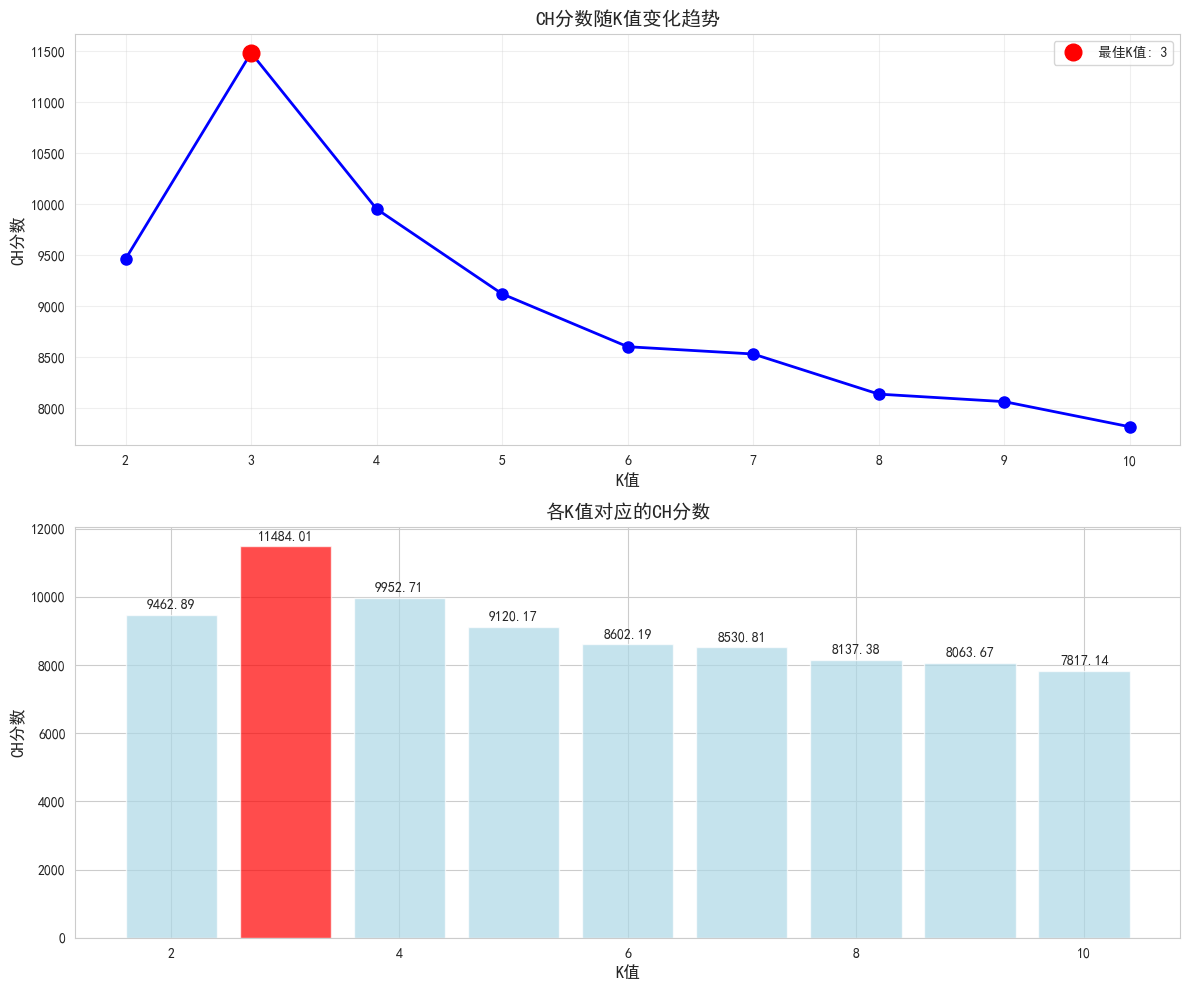


步骤4: 使用最佳K值进行聚类
------------------------------

使用最佳K值 3 进行K-means聚类完成!
聚类结果统计:
簇 0: 19696 个样本
簇 1: 20905 个样本
簇 2: 537 个样本

步骤5: 可视化聚类结果
------------------------------


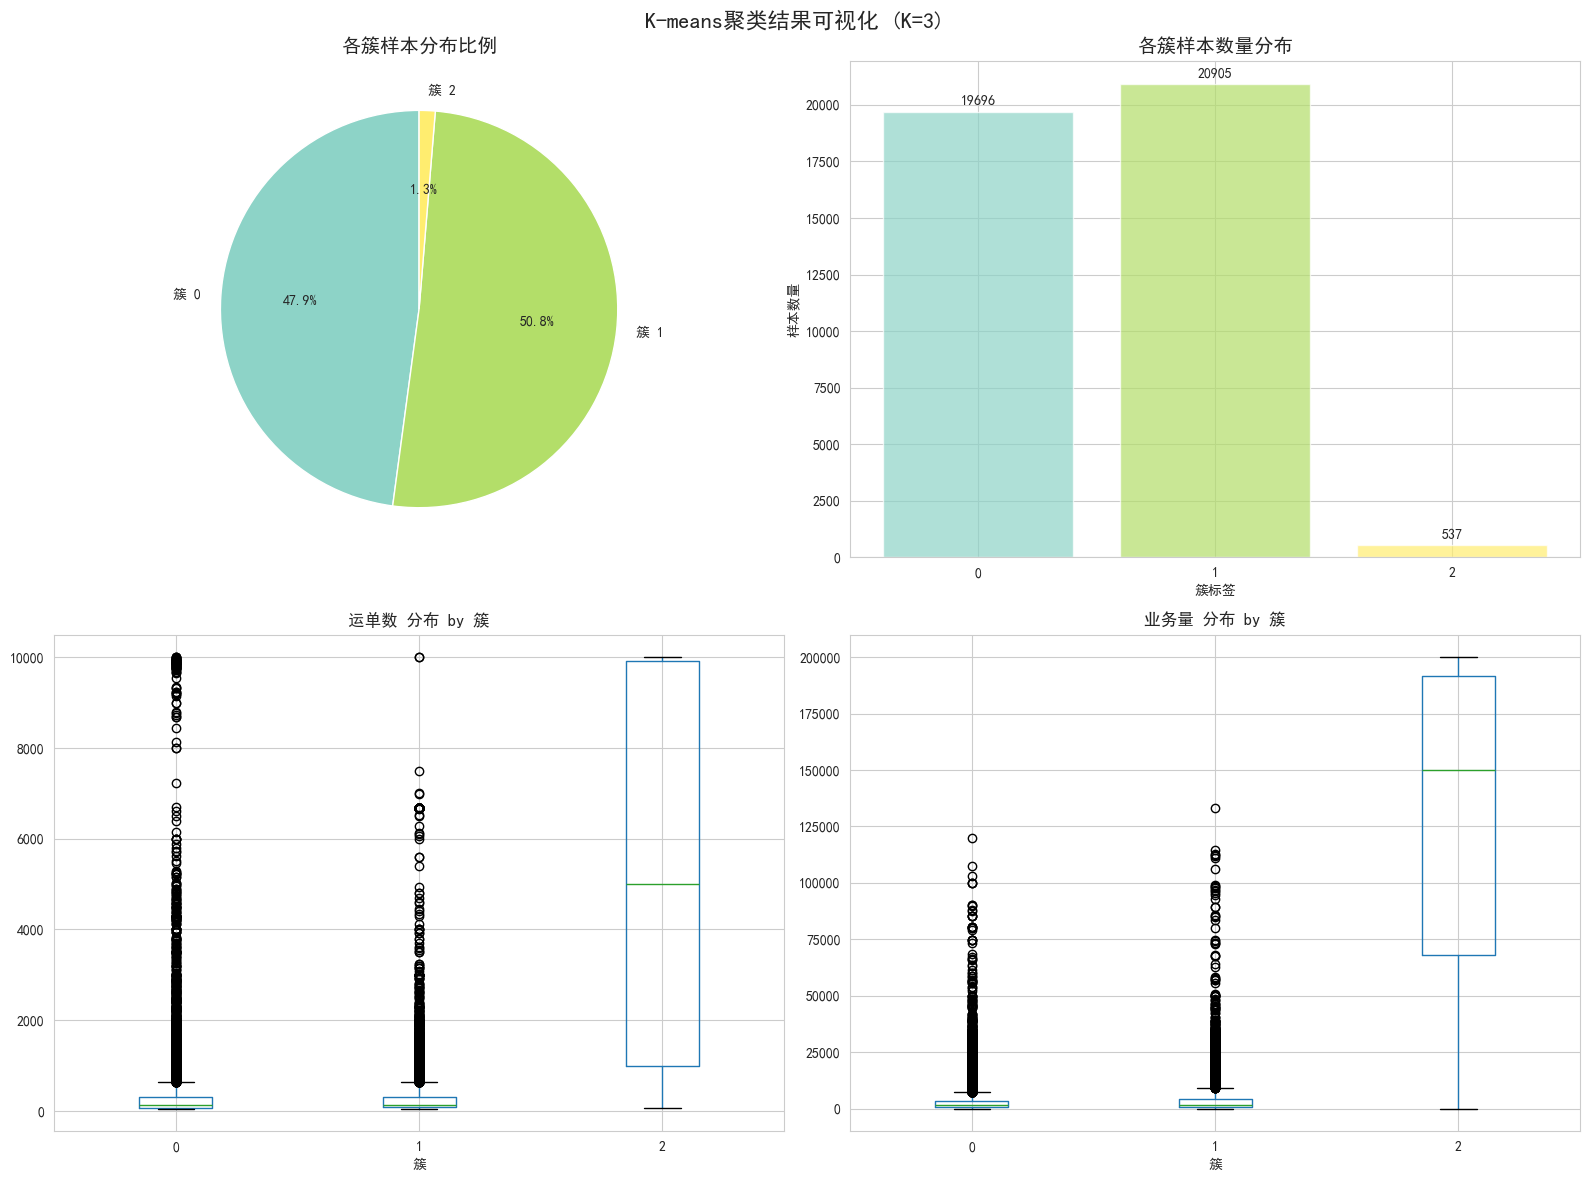


步骤6: 分析特征重要性
------------------------------


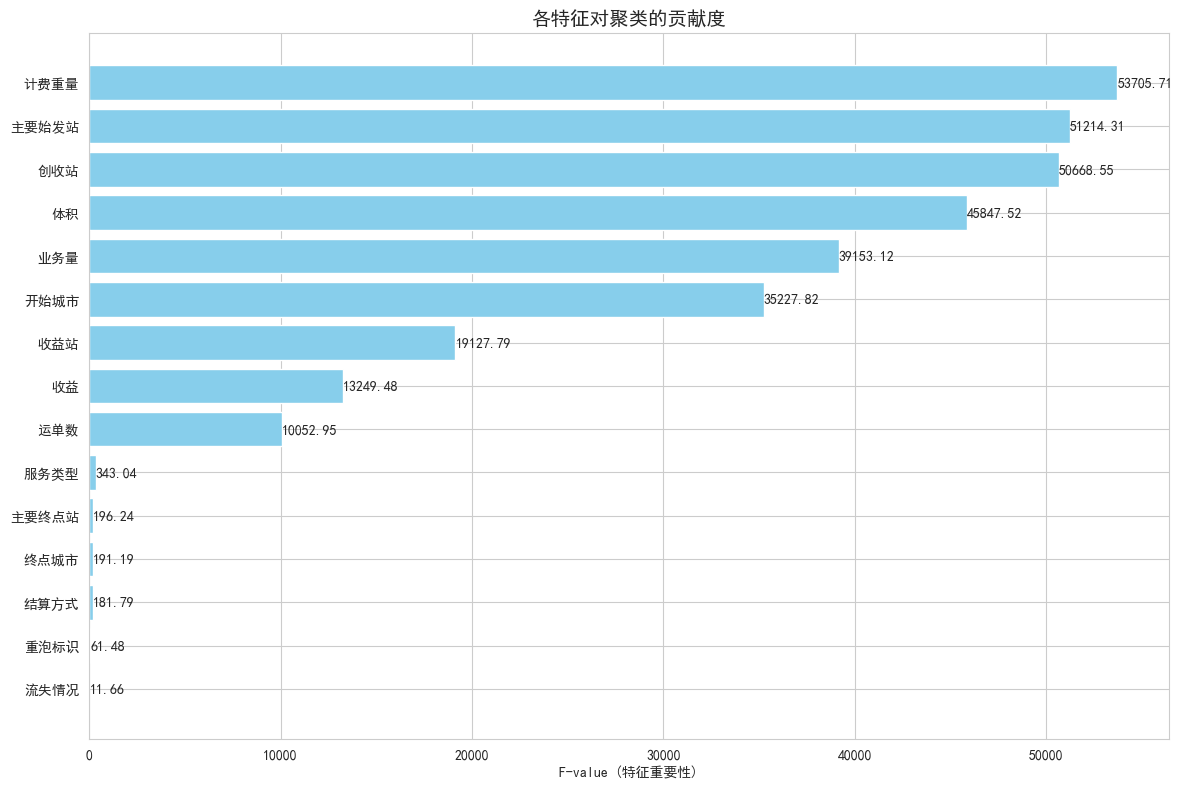

特征重要性排序:
  计费重量: F-value = 53705.71, p-value = 0.0000
  主要始发站: F-value = 51214.31, p-value = 0.0000
  创收站: F-value = 50668.55, p-value = 0.0000
  体积: F-value = 45847.52, p-value = 0.0000
  业务量: F-value = 39153.12, p-value = 0.0000
  开始城市: F-value = 35227.82, p-value = 0.0000
  收益站: F-value = 19127.79, p-value = 0.0000
  收益: F-value = 13249.48, p-value = 0.0000
  运单数: F-value = 10052.95, p-value = 0.0000
  服务类型: F-value = 343.04, p-value = 0.0000
  主要终点站: F-value = 196.24, p-value = 0.0000
  终点城市: F-value = 191.19, p-value = 0.0000
  结算方式: F-value = 181.79, p-value = 0.0000
  重泡标识: F-value = 61.48, p-value = 0.0000
  流失情况: F-value = 11.66, p-value = 0.0000

步骤7: 分析簇特征
------------------------------

各簇的统计特征:

簇 0 (共 19696 个样本, 47.9%):
----------------------------------------
最显著特征差异:
  计费重量: 5186.26 (整体: 7123.73, 差异: -27.2%)
  业务量: 3689.34 (整体: 5618.45, 差异: -34.3%)
  收益: 3594.30 (整体: 4303.74, 差异: -16.5%)
  创收站: 70.08 (整体: 41.25, 差异: +69.9%)
  运单数: 358.11 (整体: 386.32, 差异: -7.3%)

簇 1 (共 

In [8]:
from matplotlib import rcParams
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
import warnings

from sqlalchemy import create_engine
from config import MySQLConfig
warnings.filterwarnings('ignore')

# 设置中文字体
rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

# 连接到 MySQL
db = MySQLConfig()
engine_str = f"mysql+pymysql://{db.user}:{db.password}@{db.host}:{db.port}/{db.database}?charset={db.charset}"
engine = create_engine(engine_str)

print("MySQL连接成功")

# 执行 SQL 查询并加载数据
query = """SELECT * FROM DeliverInsight.customer"""
df = pd.read_sql(query, engine)

print(f"数据加载成功! 数据形状: {df.shape}")
print(f"数据列信息:")
print(df.dtypes)

class ImprovedKMeans:
    def __init__(self, max_k=10, random_state=42):
        """
        初始化改进的K-means算法

        参数:
        max_k: 最大聚类数
        random_state: 随机种子
        """
        self.max_k = max_k
        self.random_state = random_state
        self.ch_scores = []
        self.best_k = None
        self.kmeans_model = None
        self.scaler = StandardScaler()

    def calculate_ch_score(self, X, k):
        """
        计算指定k值的CH分数
        """
        kmeans = KMeans(n_clusters=k, random_state=self.random_state, n_init=10)
        labels = kmeans.fit_predict(X)

        # 使用sklearn的calinski_harabasz_score
        ch_score = calinski_harabasz_score(X, labels)

        return ch_score, kmeans

    def find_optimal_k(self, X, k_range=None):
        """
        寻找最优的K值

        参数:
        X: 输入数据
        k_range: K值范围，默认为[2, max_k]
        """
        if k_range is None:
            k_range = range(2, self.max_k + 1)

        self.ch_scores = []
        models = []

        print("正在计算各K值对应的CH分数...")
        for k in k_range:
            ch_score, model = self.calculate_ch_score(X, k)
            self.ch_scores.append(ch_score)
            models.append(model)
            print(f"K={k}, CH分数={ch_score:.4f}")

        # 找到最佳K值
        best_idx = np.argmax(self.ch_scores)
        self.best_k = list(k_range)[best_idx]
        self.kmeans_model = models[best_idx]

        print(f"\n最佳K值: {self.best_k}, 对应的CH分数: {self.ch_scores[best_idx]:.4f}")

        return self.best_k

    def plot_ch_scores(self, k_range=None):
        """
        绘制CH分数随K值变化的趋势图
        """
        if k_range is None:
            k_range = range(2, self.max_k + 1)

        # 创建子图
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

        # 子图1: CH分数折线图
        ax1.plot(k_range, self.ch_scores, 'bo-', linewidth=2, markersize=8)
        ax1.set_xlabel('K值', fontsize=12)
        ax1.set_ylabel('CH分数', fontsize=12)
        ax1.set_title('CH分数随K值变化趋势', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)

        # 标记最佳K值点
        best_idx = np.argmax(self.ch_scores)
        best_k = list(k_range)[best_idx]
        best_score = self.ch_scores[best_idx]
        ax1.plot(best_k, best_score, 'ro', markersize=12, label=f'最佳K值: {best_k}')
        ax1.legend()

        # 子图2: CH分数柱状图
        colors = ['lightblue' if k != best_k else 'red' for k in k_range]
        ax2.bar(k_range, self.ch_scores, color=colors, alpha=0.7)
        ax2.set_xlabel('K值', fontsize=12)
        ax2.set_ylabel('CH分数', fontsize=12)
        ax2.set_title('各K值对应的CH分数', fontsize=14, fontweight='bold')

        # 在柱状图上添加数值标签
        for i, v in enumerate(self.ch_scores):
            ax2.text(list(k_range)[i], v + max(self.ch_scores)*0.01, f'{v:.2f}',
                    ha='center', va='bottom', fontsize=10)

        plt.tight_layout()
        plt.show()

        return fig

    def fit(self, X):
        """
        使用最佳K值进行聚类
        """
        if self.best_k is None:
            self.find_optimal_k(X)

        # 使用最佳K值训练最终模型
        final_kmeans = KMeans(n_clusters=self.best_k, random_state=self.random_state, n_init=10)
        labels = final_kmeans.fit_predict(X)

        print(f"\n使用最佳K值 {self.best_k} 进行K-means聚类完成!")
        print(f"聚类结果统计:")
        unique, counts = np.unique(labels, return_counts=True)
        for cluster, count in zip(unique, counts):
            print(f"簇 {cluster}: {count} 个样本")

        return labels, final_kmeans

def preprocess_data(df):
    """
    数据预处理函数 - 专门针对客户数据

    参数:
    df: 原始数据
    """
    print("原始数据列信息:")
    for col in df.columns:
        print(f"  {col}: {df[col].dtype}")

    # 选择数值型特征进行聚类
    numeric_columns = []

    # 明确排除的ID类列
    explicit_exclude_columns = ['客户账号']  # 添加其他需要排除的ID列

    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            # 排除明确指定的ID类列
            if col in explicit_exclude_columns:
                print(f"排除ID类列: {col}")
                continue

            # 排除常量列（只有一个值的列）
            if df[col].nunique() <= 1:
                print(f"排除常量列: {col} (唯一值数量: {df[col].nunique()})")
                continue

            numeric_columns.append(col)

    print(f"\n数值型特征 ({len(numeric_columns)}个): {numeric_columns}")

    # 处理数值型特征
    print(f"\n使用数值型特征进行聚类: {numeric_columns}")

    if len(numeric_columns) == 0:
        print("错误: 没有找到可用的数值型特征!")
        return None, None, None, df

    # 检查并处理缺失值
    missing_values = df[numeric_columns].isnull().sum()
    if missing_values.any():
        print("发现缺失值:")
        print(missing_values[missing_values > 0])
        # 使用中位数填充缺失值
        df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

    # 选择用于聚类的数据
    X = df[numeric_columns].copy()

    # 检查数据有效性
    print(f"\n数据统计信息:")
    print(X.describe())

    # 数据标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print(f"预处理后的数据形状: {X_scaled.shape}")

    return X_scaled, numeric_columns, scaler, df

def visualize_clustering_results(df, labels, best_k, numeric_columns):
    """
    可视化聚类结果 - 不使用降维
    """
    # 创建可视化图形
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 子图1: 簇大小分布
    unique, counts = np.unique(labels, return_counts=True)
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique)))
    axes[0, 0].pie(counts, labels=[f'簇 {i}' for i in unique], autopct='%1.1f%%',
                   colors=colors, startangle=90)
    axes[0, 0].set_title('各簇样本分布比例', fontsize=14, fontweight='bold')

    # 子图2: 簇大小柱状图
    axes[0, 1].bar(unique, counts, color=colors, alpha=0.7)
    axes[0, 1].set_xlabel('簇标签')
    axes[0, 1].set_ylabel('样本数量')
    axes[0, 1].set_title('各簇样本数量分布', fontsize=14, fontweight='bold')
    axes[0, 1].set_xticks(unique)

    # 在柱状图上添加数量标签
    for i, v in enumerate(counts):
        axes[0, 1].text(unique[i], v + max(counts)*0.01, str(v),
                       ha='center', va='bottom')

    # 选择前4个最重要的特征进行可视化
    n_features = min(4, len(numeric_columns))
    selected_features = numeric_columns[:n_features]

    # 子图3: 特征分布箱线图
    df_viz = df[selected_features].copy()
    df_viz['cluster'] = labels

    # 绘制箱线图
    for i, feature in enumerate(selected_features):
        row = 1 + i // 2
        col = i % 2
        if row < 2 and col < 2:  # 确保在子图范围内
            df_viz.boxplot(column=feature, by='cluster', ax=axes[row, col])
            axes[row, col].set_title(f'{feature} 分布 by 簇')
            axes[row, col].set_xlabel('簇')

    plt.suptitle(f'K-means聚类结果可视化 (K={best_k})', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return fig

def plot_feature_importance(labels, numeric_columns, X_scaled):
    """
    分析各特征对聚类的贡献度
    """
    from sklearn.feature_selection import f_classif

    # 使用ANOVA F-value分析特征重要性
    f_values, p_values = f_classif(X_scaled, labels)

    # 创建特征重要性DataFrame
    feature_importance = pd.DataFrame({
        'feature': numeric_columns,
        'f_value': f_values,
        'p_value': p_values
    })
    feature_importance = feature_importance.sort_values('f_value', ascending=False)

    # 绘制特征重要性图
    plt.figure(figsize=(12, 8))
    y_pos = np.arange(len(feature_importance))

    plt.barh(y_pos, feature_importance['f_value'], color='skyblue')
    plt.yticks(y_pos, feature_importance['feature'])
    plt.xlabel('F-value (特征重要性)')
    plt.title('各特征对聚类的贡献度', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()

    # 添加数值标签
    for i, v in enumerate(feature_importance['f_value']):
        plt.text(v + 0.1, i, f'{v:.2f}', va='center')

    plt.tight_layout()
    plt.show()

    return feature_importance

def analyze_cluster_characteristics(df, labels, numeric_columns):
    """
    分析各簇的特征
    """
    df_cluster = df[numeric_columns].copy()
    df_cluster['cluster'] = labels

    print("\n各簇的统计特征:")
    print("=" * 60)

    # 计算各簇的均值
    cluster_means = df_cluster.groupby('cluster').mean()

    # 计算整体均值
    overall_means = df_cluster[numeric_columns].mean()

    # 计算各簇相对于整体均值的差异
    cluster_differences = cluster_means - overall_means

    # 显示结果
    for cluster in sorted(df_cluster['cluster'].unique()):
        cluster_size = sum(labels == cluster)
        percentage = (cluster_size / len(labels)) * 100
        print(f"\n簇 {cluster} (共 {cluster_size} 个样本, {percentage:.1f}%):")
        print("-" * 40)

        # 找出该簇最显著的特征
        cluster_diff = cluster_differences.loc[cluster]
        top_features = cluster_diff.abs().sort_values(ascending=False).head(5)

        print("最显著特征差异:")
        for feature in top_features.index:
            mean_val = cluster_means.loc[cluster, feature]
            overall_val = overall_means[feature]
            diff_pct = ((mean_val - overall_val) / overall_val) * 100 if overall_val != 0 else 0
            print(f"  {feature}: {mean_val:.2f} (整体: {overall_val:.2f}, 差异: {diff_pct:+.1f}%)")

    return df_cluster, cluster_means

def create_cluster_profiles(df, labels, numeric_columns):
    """
    创建客户分群画像
    """
    df_profile = df[numeric_columns].copy()
    df_profile['cluster'] = labels

    print("\n客户分群画像:")
    print("=" * 60)

    cluster_profiles = {}

    for cluster in sorted(df_profile['cluster'].unique()):
        cluster_data = df_profile[df_profile['cluster'] == cluster]
        profile = {}

        print(f"\n🎯 簇 {cluster} 客户画像:")
        print(f"   样本数量: {len(cluster_data)}")

        # 分析每个特征
        for col in numeric_columns:
            mean_val = cluster_data[col].mean()
            std_val = cluster_data[col].std()
            profile[col] = {
                'mean': mean_val,
                'std': std_val,
                'description': f"平均{mean_val:.2f} ± {std_val:.2f}"
            }
            print(f"   {col}: {mean_val:.2f} ± {std_val:.2f}")

        cluster_profiles[cluster] = profile

    return cluster_profiles

def main():
    """
    主函数
    """
    print("开始执行CH指标优化的K-means聚类分析")
    print("=" * 60)

    # 显示数据基本信息
    print(f"数据形状: {df.shape}")
    print(f"数据前5行:")
    print(df.head())

    # 步骤1: 数据预处理
    print("\n步骤1: 数据预处理")
    print("-" * 30)

    X_scaled, used_columns, scaler, processed_df = preprocess_data(df)

    if X_scaled is None:
        return None, None, None

    # 步骤2: 寻找最优K值
    print("\n步骤2: 寻找最优K值")
    print("-" * 30)

    improved_kmeans = ImprovedKMeans(max_k=10, random_state=42)
    best_k = improved_kmeans.find_optimal_k(X_scaled)

    # 步骤3: 绘制CH分数趋势图
    print("\n步骤3: 绘制CH分数趋势图")
    print("-" * 30)

    k_range = range(2, 11)  # 从2到10
    improved_kmeans.plot_ch_scores(k_range)

    # 步骤4: 使用最佳K值进行聚类
    print("\n步骤4: 使用最佳K值进行聚类")
    print("-" * 30)

    labels, final_model = improved_kmeans.fit(X_scaled)

    # 步骤5: 可视化聚类结果
    print("\n步骤5: 可视化聚类结果")
    print("-" * 30)

    visualize_clustering_results(processed_df, labels, best_k, used_columns)

    # 步骤6: 分析特征重要性
    print("\n步骤6: 分析特征重要性")
    print("-" * 30)

    feature_importance = plot_feature_importance(labels, used_columns, X_scaled)
    print("特征重要性排序:")
    for i, row in feature_importance.iterrows():
        print(f"  {row['feature']}: F-value = {row['f_value']:.2f}, p-value = {row['p_value']:.4f}")

    # 步骤7: 分析簇特征
    print("\n步骤7: 分析簇特征")
    print("-" * 30)

    df_cluster, cluster_means = analyze_cluster_characteristics(processed_df, labels, used_columns)

    # 步骤8: 创建客户分群画像
    print("\n步骤8: 创建客户分群画像")
    print("-" * 30)

    cluster_profiles = create_cluster_profiles(processed_df, labels, used_columns)

    # 步骤9: 输出最终结果
    print("\n步骤9: 最终结果总结")
    print("-" * 30)
    print(f"最佳聚类数目 K: {best_k}")
    print(f"最高CH分数: {max(improved_kmeans.ch_scores):.4f}")
    print(f"各簇样本分布:")
    unique, counts = np.unique(labels, return_counts=True)
    for cluster, count in zip(unique, counts):
        percentage = (count / len(labels)) * 100
        print(f"  簇 {cluster}: {count} 个样本 ({percentage:.1f}%)")

    # 将聚类结果添加到原始数据中
    df_result = df.copy()
    df_result['cluster'] = labels

    print("\n✅ 聚类分析完成!")
    return df_result, improved_kmeans, final_model, feature_importance

# 如果直接运行此脚本
if __name__ == "__main__":
    # 执行主函数
    result_df, improved_kmeans, final_model, feature_importance = main()

    # 如果聚类成功，可以保存结果或进行进一步分析
    if result_df is not None:
        print(f"\n📊 聚类结果已添加到数据中，数据形状: {result_df.shape}")

        # 显示聚类结果摘要
        print("\n聚类结果摘要:")
        cluster_summary = result_df['cluster'].value_counts().sort_index()
        for cluster, count in cluster_summary.items():
            percentage = (count / len(result_df)) * 100
            print(f"  簇 {cluster}: {count} 个客户 ({percentage:.1f}%)")

        # 可选：保存聚类结果到CSV文件
        try:
            result_df.to_csv('customer_clustering_results.csv', index=False, encoding='utf-8-sig')
            print("💾 聚类结果已保存到 customer_clustering_results.csv")
        except Exception as e:
            print(f"保存到CSV文件失败: {e}")

        # 可选：将结果保存回数据库
        try:
            result_df.to_sql('customer_clusters', engine, if_exists='replace', index=False)
            print("💾 聚类结果已保存到数据库表 'customer_clusters'")
        except Exception as e:
            print(f"保存到数据库失败: {e}")

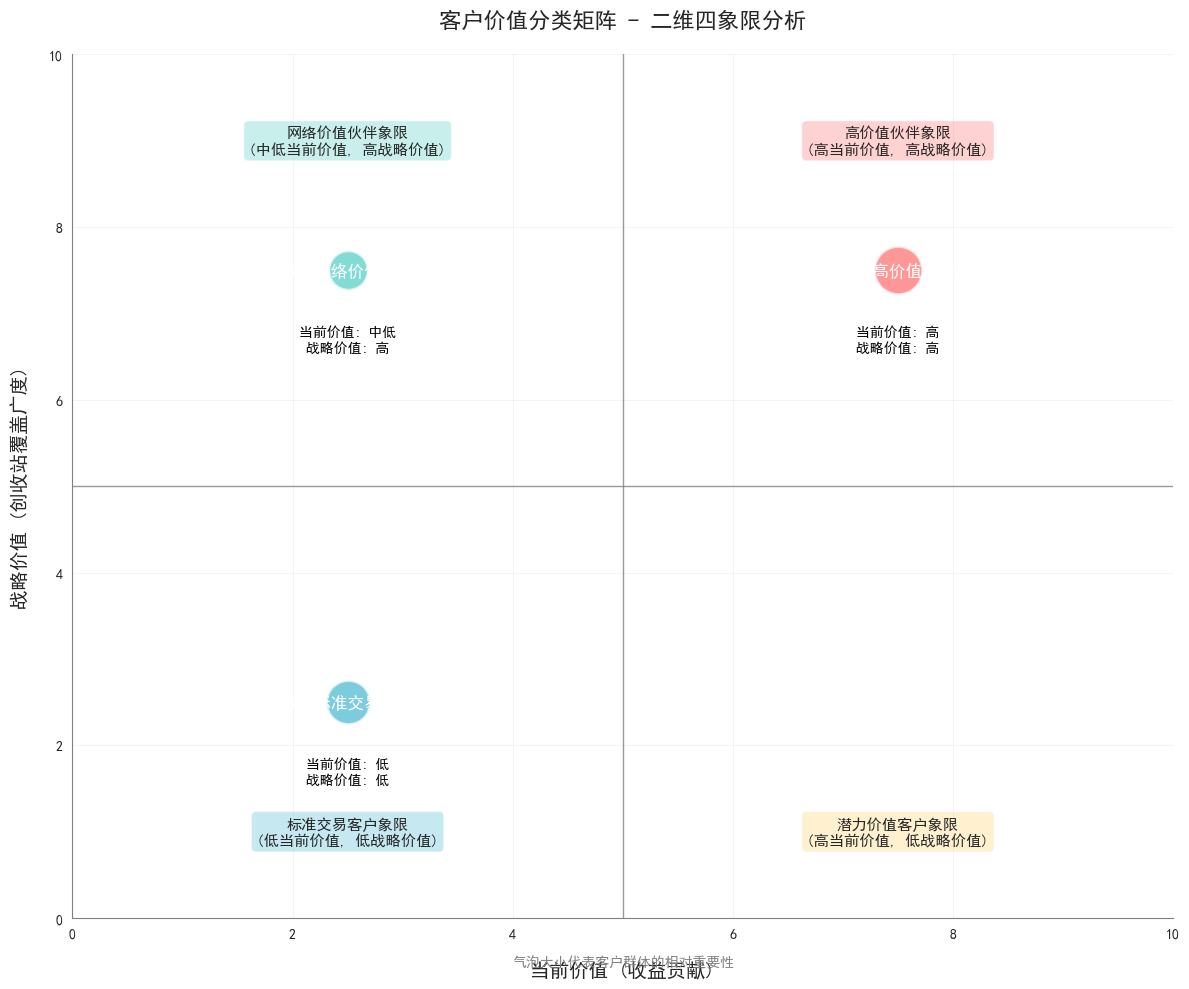

客户价值分类详细分析表
       客户群体  客户数量    占比 当前价值水平 战略价值水平              核心特征             管理策略
 高价值伙伴 (簇2)   537  1.3%      高      高 极高业务量与收益贡献，广泛网络覆盖 战略合作、深度绑定、优先资源投入
网络价值伙伴 (簇0) 19696 47.9%     中低      高   中等业务量，但网络覆盖广度突出   培育发展、网络协同、挖掘潜力
标准交易客户 (簇1) 20905 50.8%      低      低      基础业务量，网络覆盖有限  效率优化、标准化服务、成本控制


四象限战略管理分析
      象限       客户分布 资源投入优先级  管理重点   预期收益
 高价值伙伴象限  簇2 (1.3%)      最高 维护与深耕 核心利润来源
网络价值伙伴象限 簇0 (47.9%)       高 发展与转化 长期战略价值
标准交易客户象限 簇1 (50.8%)      标准 效率与稳定 规模效应价值
潜力价值客户象限       暂未发现     待评估 识别与培育 潜在增长价值


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Circle, ConnectionPatch

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 创建画布和坐标轴
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# 设置坐标轴范围
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

# 绘制象限分界线
ax.axvline(x=5, color='gray', linestyle='-', alpha=0.8, linewidth=1)
ax.axhline(y=5, color='gray', linestyle='-', alpha=0.8, linewidth=1)

# 定义客户群体的坐标和属性
clusters_data = {
    '簇2-高价值伙伴': {
        'position': (7.5, 7.5),
        'color': '#FF6B6B',
        'size': 1200,
        'current_value': '高',
        'strategic_value': '高'
    },
    '簇0-网络价值伙伴': {
        'position': (2.5, 7.5),
        'color': '#4ECDC4',
        'size': 800,
        'current_value': '中低',
        'strategic_value': '高'
    },
    '簇1-标准交易客户': {
        'position': (2.5, 2.5),
        'color': '#45B7D1',
        'size': 1000,
        'current_value': '低',
        'strategic_value': '低'
    }
}

# 绘制客户群体气泡
for cluster_name, cluster_info in clusters_data.items():
    x, y = cluster_info['position']
    color = cluster_info['color']
    size = cluster_info['size']

    # 绘制气泡
    scatter = ax.scatter(x, y, s=size, c=color, alpha=0.7, edgecolors='white', linewidth=2)

    # 添加客户群体名称
    ax.text(x, y, cluster_name, fontsize=12, ha='center', va='center',
            fontweight='bold', color='white')

    # 添加价值描述
    value_text = f"当前价值: {cluster_info['current_value']}\n战略价值: {cluster_info['strategic_value']}"
    ax.text(x, y-0.8, value_text, fontsize=10, ha='center', va='center',
            color='black', style='italic')

# 设置坐标轴标签
ax.set_xlabel('当前价值 (收益贡献)', fontsize=14, fontweight='bold', labelpad=15)
ax.set_ylabel('战略价值 (创收站覆盖广度)', fontsize=14, fontweight='bold', labelpad=15)

# 设置标题
ax.set_title('客户价值分类矩阵 - 二维四象限分析', fontsize=16, fontweight='bold', pad=20)

# 添加象限标签
ax.text(2.5, 9, '网络价值伙伴象限\n(中低当前价值, 高战略价值)',
        fontsize=11, ha='center', va='center', style='italic',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='#4ECDC4', alpha=0.3))
ax.text(7.5, 9, '高价值伙伴象限\n(高当前价值, 高战略价值)',
        fontsize=11, ha='center', va='center', style='italic',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='#FF6B6B', alpha=0.3))
ax.text(2.5, 1, '标准交易客户象限\n(低当前价值, 低战略价值)',
        fontsize=11, ha='center', va='center', style='italic',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='#45B7D1', alpha=0.3))
ax.text(7.5, 1, '潜力价值客户象限\n(高当前价值, 低战略价值)',
        fontsize=11, ha='center', va='center', style='italic',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='#FFD166', alpha=0.3))

# 添加图例说明
legend_text = "气泡大小代表客户群体的相对重要性"
ax.text(5, -0.5, legend_text, fontsize=10, ha='center', va='center',
        style='italic', color='gray')

# 美化图形
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')

# 设置网格
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

# 创建详细的数据表格
cluster_details = pd.DataFrame({
    '客户群体': ['高价值伙伴 (簇2)', '网络价值伙伴 (簇0)', '标准交易客户 (簇1)'],
    '客户数量': [537, 19696, 20905],
    '占比': ['1.3%', '47.9%', '50.8%'],
    '当前价值水平': ['高', '中低', '低'],
    '战略价值水平': ['高', '高', '低'],
    '核心特征': [
        '极高业务量与收益贡献，广泛网络覆盖',
        '中等业务量，但网络覆盖广度突出',
        '基础业务量，网络覆盖有限'
    ],
    '管理策略': [
        '战略合作、深度绑定、优先资源投入',
        '培育发展、网络协同、挖掘潜力',
        '效率优化、标准化服务、成本控制'
    ]
})

print("客户价值分类详细分析表")
print("=" * 100)
print(cluster_details.to_string(index=False))
print("\n")

# 创建数值化的象限分析数据
quadrant_analysis = {
    '象限': ['高价值伙伴象限', '网络价值伙伴象限', '标准交易客户象限', '潜力价值客户象限'],
    '客户分布': ['簇2 (1.3%)', '簇0 (47.9%)', '簇1 (50.8%)', '暂未发现'],
    '资源投入优先级': ['最高', '高', '标准', '待评估'],
    '管理重点': ['维护与深耕', '发展与转化', '效率与稳定', '识别与培育'],
    '预期收益': ['核心利润来源', '长期战略价值', '规模效应价值', '潜在增长价值']
}

quadrant_df = pd.DataFrame(quadrant_analysis)
print("四象限战略管理分析")
print("=" * 80)
print(quadrant_df.to_string(index=False))

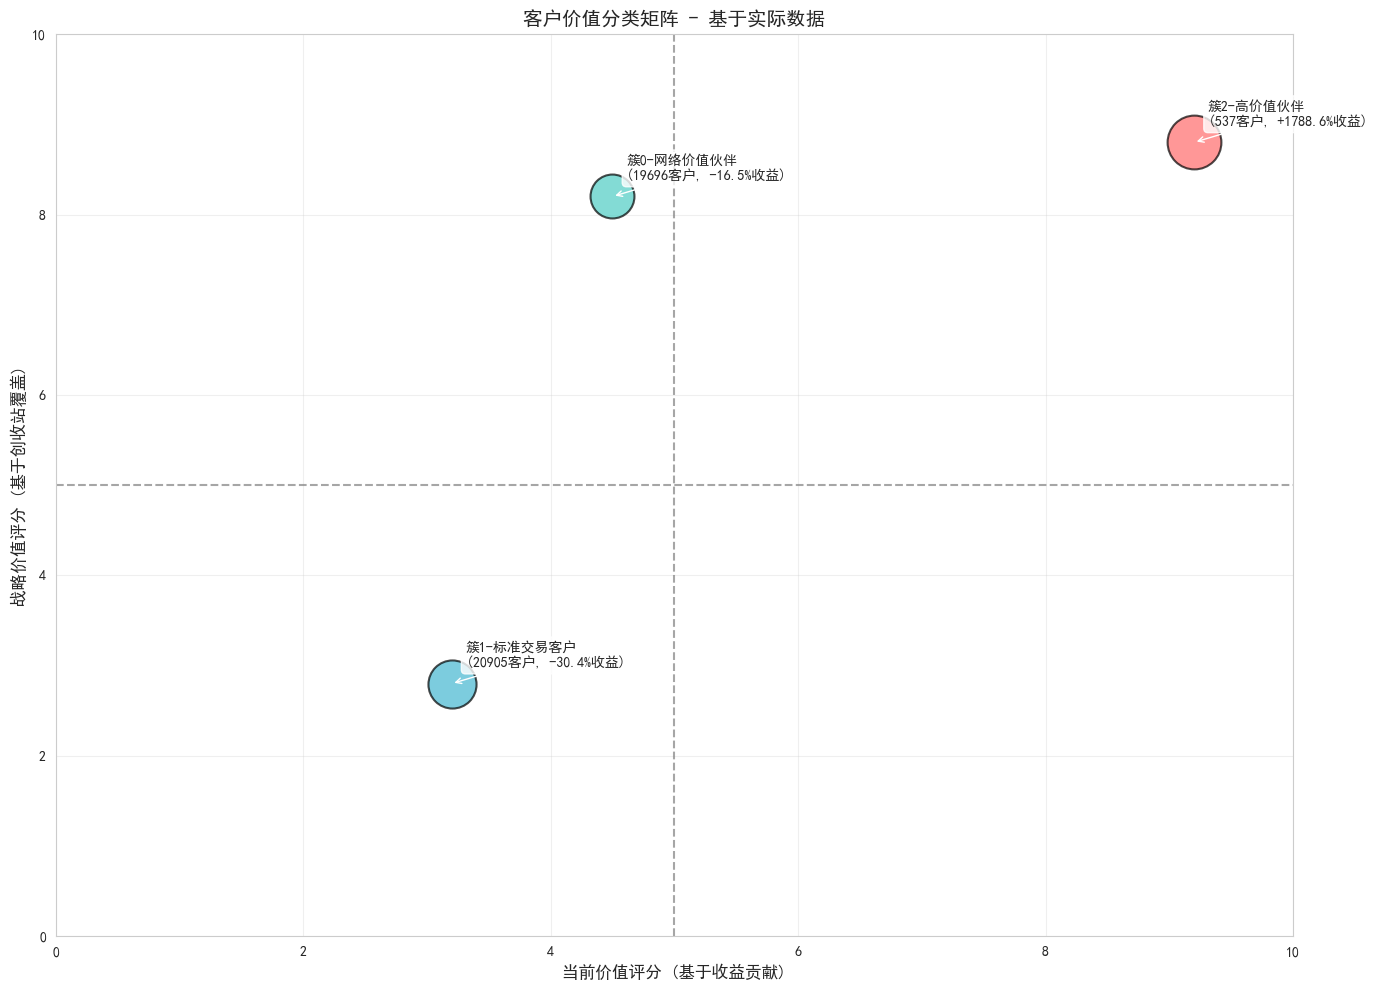

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 基于实际数据创建精确的二维矩阵
def create_precise_customer_matrix():
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))

    # 使用实际数据标准化后的值
    # 假设数据已经过标准化处理 (0-10分制)
    clusters_precise = {
        '簇2-高价值伙伴': {
            'current_value': 9.2,  # 基于收益贡献的评分
            'strategic_value': 8.8,  # 基于创收站覆盖的评分
            'size': 1500,
            'color': '#FF6B6B',
            'revenue_ratio': 1788.6,  # 收益超出整体%
            'network_ratio': 53.0,   # 创收站超出整体%
            'customer_count': 537
        },
        '簇0-网络价值伙伴': {
            'current_value': 4.5,
            'strategic_value': 8.2,
            'size': 1000,
            'color': '#4ECDC4',
            'revenue_ratio': -16.5,  # 收益低于整体%
            'network_ratio': 69.9,   # 创收站超出整体%
            'customer_count': 19696
        },
        '簇1-标准交易客户': {
            'current_value': 3.2,
            'strategic_value': 2.8,
            'size': 1200,
            'color': '#45B7D1',
            'revenue_ratio': -30.4,  # 收益低于整体%
            'network_ratio': -67.2,  # 创收站低于整体%
            'customer_count': 20905
        }
    }

    # 绘制气泡图
    for cluster_name, cluster_data in clusters_precise.items():
        x = cluster_data['current_value']
        y = cluster_data['strategic_value']

        scatter = ax.scatter(x, y, s=cluster_data['size'],
                           c=cluster_data['color'], alpha=0.7,
                           edgecolors='black', linewidth=1.5)

        # 添加标注
        label = f"{cluster_name}\n({cluster_data['customer_count']}客户, {cluster_data['revenue_ratio']:+.1f}%收益)"
        ax.annotate(label, (x, y), xytext=(10, 10), textcoords='offset points',
                   fontsize=10, ha='left', va='bottom',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    # 设置坐标轴
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axvline(x=5, color='gray', linestyle='--', alpha=0.7)
    ax.axhline(y=5, color='gray', linestyle='--', alpha=0.7)

    ax.set_xlabel('当前价值评分 (基于收益贡献)', fontsize=12, fontweight='bold')
    ax.set_ylabel('战略价值评分 (基于创收站覆盖)', fontsize=12, fontweight='bold')
    ax.set_title('客户价值分类矩阵 - 基于实际数据', fontsize=14, fontweight='bold')

    # 添加网格
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return clusters_precise

# 执行精确版本
precise_data = create_precise_customer_matrix()